# Practical Session 2
### Kernel Methods for Machine Learning

Written by Yunlong Jiao / Romain Menegaux, 21 June 2022

In [20]:
# setup
import numpy as np

In [21]:
import sys
print(sys.version)

3.9.16 (main, Mar  8 2023, 14:00:05) 
[GCC 11.2.0]


In [22]:
import sklearn
from sklearn import linear_model as lm
sklearn.__version__

'1.2.2'

***
## Tasks

1. Implement (naive) solvers to Ridge Regression, Weighted Ridge Regression and Logistic Ridge Regression. See notes for the mathematical derivation.
2. Simulate some toy data to check if our solvers give correct solutions.

***
### Ridge Regression (RR)

Given $X \in \mathbb{R}^{n \times p}$ and $y \in \mathbb{R}^n$, solve
$$
\min_{\beta \in \mathbb{R}^p} \frac{1}{n} \|y - X \beta\|^2 + \lambda \|\beta\|^2 \,.
$$

In [23]:
# Ridge Regression (RR)
def solveRR(y, X, lam):
    n, p = X.shape
    assert (len(y) == n)
    beta = np.linalg.solve(X.T.dot(X)+lam*n*np.eye(p), X.T.dot(y))
    # Hint:
    # beta = np.linalg.solve(A, b)
    # Finds solution to the linear system Ax = b
    return (beta)

### Evaluation of our Ridge Regression solver:
#### One-dimensional data
(for visualization purposes)

In [24]:
np.random.seed(42)
n = 100
X = np.random.rand(n)
beta_star = 0.8
y = X * beta_star + 0.1 * np.random.normal(0, 1, n)

lam = .1
beta_hat = solveRR(y, X[:, None], lam)

print(beta_hat)

[0.59426913]


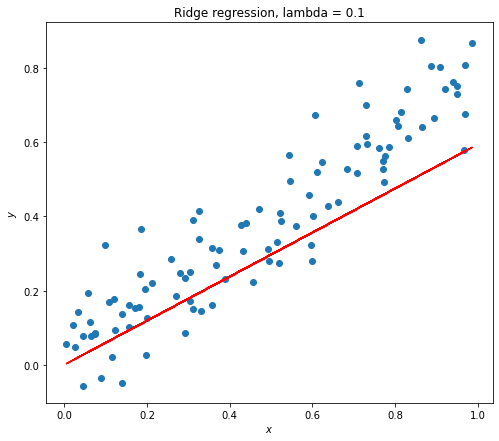

In [25]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,7))
plt.title('Ridge regression, lambda = {}'.format(lam))
plt.scatter(X, y)
plt.plot(X, X * beta_hat, c='r')
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.show()

#### Evaluation on p-dimensional data
---

In [26]:
# Toy data
np.random.seed(42) # for reproducibility
n = 100 # number of samples
p = 10 # number of features
X = np.random.normal(0, 1, (n, p))
X = sklearn.preprocessing.scale(X) # scale to 0 mean and 1 standard deviation
beta_star = np.random.normal(0, 1, p)
# y = X * beta + noise
y = X.dot(beta_star) + 0.2 * np.random.normal(0, 1, n) 

def compare(beta1, beta2):
    print('''
Our solver:
{}
Scikit-learn:
{}

Difference between the two:
{:.1e}
        '''.format(beta1.round(2), beta2.round(2), float(np.sum((beta1-beta2)**2)))
    )

In [27]:
lam = 0.1

# Our solver
beta1 = solveRR(y, X, lam)

# Python solver
alpha = lam * X.shape[0]
model = lm.Ridge(alpha=alpha, fit_intercept=False)
beta2 = model.fit(X, y).coef_

# Check
compare(beta1, beta2)


Our solver:
[ 1.28  0.79  0.05 -0.55  0.65  0.33  0.77  0.63  0.97 -0.53]
Scikit-learn:
[ 1.28  0.79  0.05 -0.55  0.65  0.33  0.77  0.63  0.97 -0.53]

Difference between the two:
3.1e-31
        


***
### Weighted Ridge Regression (WRR)

Given $X \in \mathbb{R}^{n \times p}$ and $y \in \mathbb{R}^n$, and weights $w \in \mathbb{R}^n_+$, solve
$$
\min_{\beta \in \mathbb{R}^p} \frac{1}{n} \sum_{i=1}^n w_i (y_i - \beta^\top x_i)^2 + \lambda \|\beta\|^2 \,.
$$

**Goal:** Express the objective as a regular Ridge Regression (RR)

In [28]:
# Weighted Ridge Regression (WRR)
def solveWRR(y, X, w, lam):
    n, p = X.shape
    assert (len(y) == len(w) == n)
    beta = solveRR(np.sqrt(w)*y, np.sqrt(w)[:,None]*X, lam)
    # Hint:
    # Find y1 and X1 such that:
    # beta = solveRR(y1, X1, lam)
    return (beta)

**Try it out:**

In [29]:
lam = 0.1
w = np.random.rand(len(y))

# Our solver
beta1 = solveWRR(y, X, w, lam)

# Python solver
alpha = lam * X.shape[0]
model = lm.Ridge(alpha=alpha, fit_intercept=False)
beta2 = model.fit(X, y, sample_weight=w).coef_

# Check
compare(beta1, beta2)


Our solver:
[ 1.22  0.69  0.05 -0.5   0.6   0.27  0.66  0.6   0.86 -0.51]
Scikit-learn:
[ 1.22  0.69  0.05 -0.5   0.6   0.27  0.66  0.6   0.86 -0.51]

Difference between the two:
2.2e-31
        


***
## Logistic Ridge Regression (LRR)
----

Given $X \in \mathbb{R}^{n \times p}$ and $y \in \{-1,+1\}^n$, solve
$$
\min_{\beta \in \mathbb{R}^p} \frac{1}{n} \sum_{i=1}^n \log (1+e^{-y_i \beta^\top x_i}) + \lambda \|\beta\|^2 \,.
$$

Let $\sigma(x) = \frac{1}{1 + e^{-x}}$ be the sigmoid function.

**Exercise:** Compute $\sigma'(x)$

$ \sigma'(x) =  \frac{e^{-x}}{(1+e^{-x})^2} = \sigma(x)(1-\sigma(x)) =\sigma(x)\sigma(-x)$

Rewriting $J$:
$$
J(\beta) = - \frac{1}{n} \sum_{i=1}^n {\log(\sigma(y_i\beta^\top x_i))} + \lambda \|\beta\|^2 \,.
$$

**Exercise:** Compute its gradient $\nabla J$, and its Hessian $\nabla^2 J$

#### Computation of $\nabla J(\beta)$:

\begin{align*}
\nabla J(\beta) &= -\frac{1}{n} \sum_{i=1}^n \frac{\nabla_\beta (\sigma(y_i\beta^\top x_i)}{\sigma(y_i\beta^Tx_i)} +2\lambda \beta \quad \left( \nabla_\beta \log f(\beta) = \frac{\nabla_\beta f}{f(\beta)} \right ) \\
& = -\frac{1}{n} \sum_{i=1}^n \frac{y_i\sigma'(y_i\beta^\top x_i)}{\sigma(y_i\beta^Tx_i)}x_i + 2\lambda \beta \\
& = -\frac{1}{n}\sum_{i=1}^n y_i\sigma(-y_i\beta^\top x_i)x_i + 2\lambda\beta \quad (\sigma'(x) = \sigma(x) \sigma(-x))
\end{align*}
**OR**
Component-wise: $$ \frac{\partial}{\partial \beta_j} \log(\sigma(y_i \beta^\top x_i)) = \frac{\frac{\partial}{\partial \beta_j} \left ( \sigma(y_i \beta^\top x_i) \right )}{\sigma(y_i \beta^\top x_i} = \frac{y_i\sigma'(y_i\beta^Tx_{i})}{\sigma(y_i\beta^\top x_i)}x_{ij} $$


#### Computation of $\nabla^2 J(\beta)$:

$$
\nabla^2 J(\beta) = \frac{1}{n}\sum_{i=1}^n \sigma(y_i\beta^Tx_i)\sigma(-y_i\beta^\top x_i) x_ix_i^T + 2\lambda I
$$

**OR**
Component-wise:
$$\nabla^2 J(\beta)_{j,k} = \frac{\partial^2 J}{\partial \beta_j \partial \beta_k} $$
$$ \nabla^2 J(\beta)_{j} = \frac{1}{n}\sum_{i=1}^n \sigma(y_i\beta^Tx_i)\sigma(-y_i\beta^T x_{i})x_{ij}x_i + 2\lambda \mathbf{\delta}_{j} $$
and at position $k$, we get 
$$ \nabla^2 J(\beta)_{jk} = \frac{1}{n}\sum_{i=1}^n \sigma(y_i\beta^T x_{i})\sigma(-y_i\beta^T x_{i})x_{ij}x_{ik} + 2\lambda \mathbf{1}_{k=j} $$

### Gradient descent

- Initialize $\beta^{old} = \beta_0$
- Repeat until convergence: $$
\beta^{new} \leftarrow \beta^{old} - h \nabla J(\beta^{old})
$$
where $h$ is the step size (learning rate)

Under some conditions on $J$ (for example $J$ is strongly convex), and with an appropriate step-size $h$, this algorithm converges to a point $\beta^*$ such that $\nabla J(\beta^*) = 0$  

### Implementation of Logistic Ridge Regression with Gradient Descent
---

$$
\nabla J(\beta) = -\frac{1}{n}\sum_{i=1}^n y_i\sigma(-y_i\beta^\top x_i)x_i + 2\lambda\beta
$$

In [30]:
# Logistic Ridge Regression (LRR) with gradient descent (GD)
def solveLRR_gradient(y, X, lam, h=0.01, max_iter=500, eps=1e-12):
    '''
    lam: Regularization parameter
    max_iter: Max number of iterations of gradient descent
    eps: Tolerance for stopping criteria 
    '''
    n, p = X.shape
    assert (len(y) == n)
 
    beta = np.zeros(p)
    
    def sigmoid(x):
        return 1 / (1 + np.exp(-x))
            
    for i in range(max_iter):
        s = sigmoid(-y*X.dot(beta))
        grad = -(y*s).dot(X)/n + 2*lam*beta 
        if np.mean((h*grad)**2)<eps:
           break
        beta -= h*grad
    return beta

**Try it out:**

In [31]:
y_bin = np.sign(y) # Binarize targets
lam = 0.1

# Our solver
beta_gradient = solveLRR_gradient(y_bin, X, lam, max_iter=5000)

# Python solver
alpha = 2 * lam * X.shape[0]
model = lm.LogisticRegression(C=1/alpha, fit_intercept=False)
beta_sklearn = model.fit(X, y_bin).coef_

# Check
compare(beta_gradient, beta_sklearn)


Our solver:
[ 0.5   0.31 -0.09 -0.17  0.27  0.15  0.35  0.32  0.3  -0.39]
Scikit-learn:
[[ 0.5   0.32 -0.09 -0.17  0.27  0.15  0.36  0.32  0.3  -0.39]]

Difference between the two:
9.6e-07
        


***
### Mini Data Challenge

We will try to predict whether patients have breast cancer.

We use scikit-learn's [breast cancer dataset](https://scikit-learn.org/stable/datasets/index.html#breast-cancer-dataset)

30 features, 569 samples, 2 labels ('malignant' or 'benign')

In [32]:
# Load data and split into training / validation sets
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

# X, y = load_breast_cancer(return_X_y=True)
data = load_breast_cancer()
X, y = data['data'], data['target']
y = 2*y - 1 # transform from {0, 1} to {-1, 1}

# Hint: Scaling can be important
X = sklearn.preprocessing.scale(X)

# Split the dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)
X.shape

(569, 30)

In [33]:
# Fit our model and compute its parameters
lam = 0.01
beta = solveLRR_gradient(y_train, X_train, lam)

In [34]:
def sigmoid(x):
    return 1/(1+np.exp(-x))

# Compute predicted probabilities and classes
probas_pred = sigmoid(X_test.dot(beta))
y_pred = np.sign(probas_pred-0.5)

#### Performance evaluation
---

In [35]:
from sklearn.metrics import accuracy_score, roc_auc_score

print("Our model's performance:")
print('Accuracy: {:.2%}'.format(accuracy_score(y_test, y_pred)))
print('AUC: {:.2%}'.format(roc_auc_score(y_test, probas_pred)))

Our model's performance:
Accuracy: 96.81%
AUC: 99.78%


In [36]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          -1       0.93      0.99      0.96        67
           1       0.99      0.96      0.97       121

    accuracy                           0.97       188
   macro avg       0.96      0.97      0.97       188
weighted avg       0.97      0.97      0.97       188



#### Plotting the feature importances
---

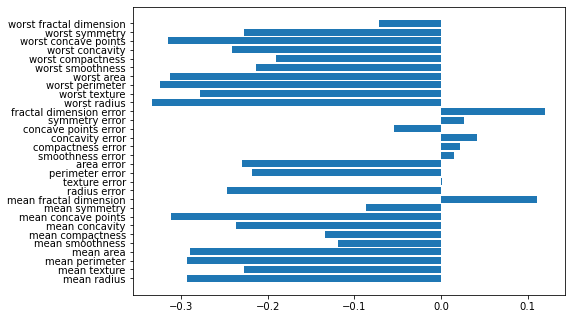

In [37]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
features = data['feature_names']
ax.barh(features, beta)
plt.show()